<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Lab #1: ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 
This is first laboratory task for the course TSA.
The Lab is desinged to impove skills of tuning parameters of ES models and get experience of coding of simple Regression Models.

The Lab should take about 5-6 hours to be completed.

<h1 align="center">Important Info</h1> 
- <span style="font-size: 14pt;"> You must send your solution to the email </span> <span style="color:red; font-size: 12pt;">alexromsput@gmail.com, </span>
- The theme of your message must be <span style="color:red; font-size: 12pt;"> TSA-Erevan-2017-[Your Surname] </span>, for exmaple -- TSA-Erevan-2017-Romanenko,
- You can send ipnb file in attachment or just a link to github. The file in attachment of the letter must be named as <span style="color:red; font-size: 12pt;"> [Surname]-[Group]-Lab1.ipnb</span>, for example -- Romanenko-Evening-Lab1.ipnb,
  
<span style="color:red; font-size: 14pt;"> DEADLINE: 10 June 2017 23:59:59 </span>


<h1 align="center">1. Using ARIMA for wage and electricity comsumption datasets (50%)</h1>
Solve the task for Practice day 2.

Link for Practice day 2: https://github.com/DanielBaghdasaryan/TS/blob/master/Task%20for%20Practice%20Day%202.ipynb

<h1 align="center">2. Forecasting of real TS (50%)</h1>
Build the forecast for a dataset  according to the scheme in task 2 (in Practice day 2). You can find the link to dataset that you need to forecast at the sheet 'Lab2' <a href="https://drive.google.com/open?id=11-lzxxR0aeBmEDGEW1GiIaP4X3fyCTHxTg4b0wALpzs">here</a>. 
     


<h1 align="center">1. Reading Data</h1>

In [2]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
import time
import warnings as w
import plotly.plotly as py
from IPython.display import Image

%matplotlib inline

def qualityMACAPE(x,y):
    qlt = (2*(x-y).abs()/(x+y)).abs().replace([np.inf, -np.inf], np.nan)
    return qlt.mean()

/home/daniel/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/home/daniel/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



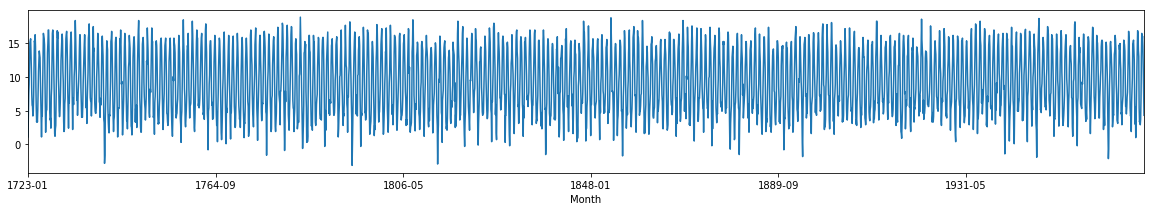

In [3]:
ts = pd.read_csv('monthly-temperature-in-england-f.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True).dropna()
# Cleaning
ts['Monthly temperature in England (F), 1723-1970']=ts['Monthly temperature in England (F), 1723-1970'].str.replace('?','-').convert_objects(convert_numeric=True)

ts['Monthly temperature in England (F), 1723-1970'].plot(figsize=(20,3))
plt.show()

<h3><span style="color:red">REPORT</span></h3><br />
It's clear that season is 12 (a year)

<br /><br /><br />
<h1 align="center">2. SARIMA model for Monthly temperature in England</h1>
<h1 align="center">2.1 Select SARIMA parameters</h1>
## 2.1.0. Trim Data
Using Data before 1910-01

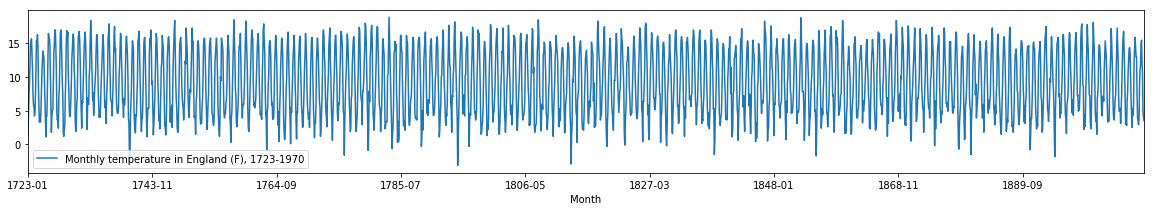

In [4]:
ts_body=ts[:'1910-01']
ts_body.plot(figsize=(20,3))
plt.show()

<br /><br />
## 2.1.1. Differentation

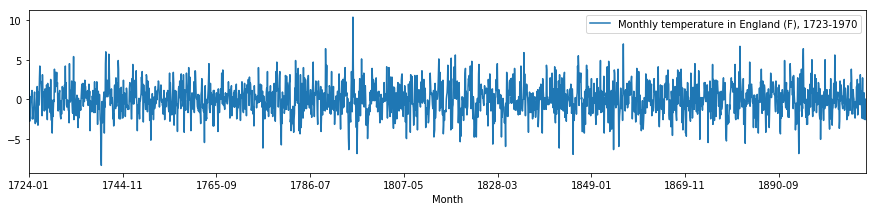

In [4]:
diff = ts_body

diff = (diff  - diff.shift(12))[12:] #Seasonal derivative

# diff = (diff  - diff.shift(1))[1:] #Simple derivative

diff.plot(figsize=(15,3))


## 2.1.2. ACF / PACF

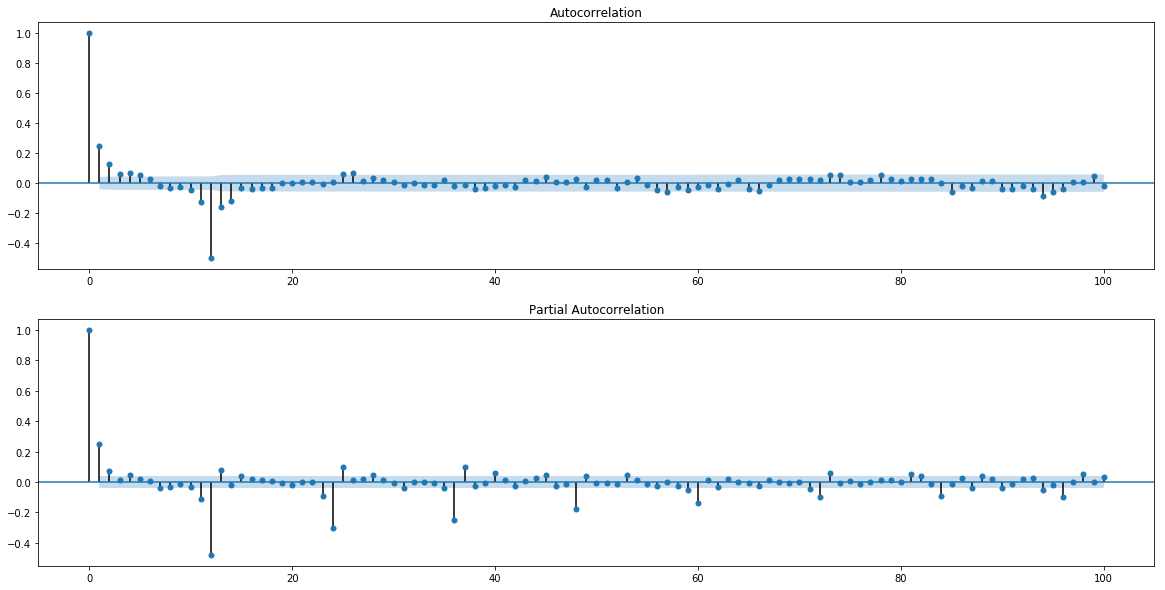

In [31]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff.values.squeeze(), lags=100, ax=ax2)

<h3><span style="color:red">REPORT</span></h3><br />
One seasonal differentation seems enough to get stationarity and start to chose parameters

<br />
## 2.1.3. AIC-s comparision

In [24]:
mod = sm.tsa.statespace.SARIMAX(diff, trend='c', order=(1,0,2), seasonal_order=(1,0,1,12)).fit()
print(mod.aic)
print(mod.bic)

7785.94546606
7825.92317482


<h3><span style="color:red">REPORT</span></h3>
1. I manually checked numbers (1,2,3) for parameters (p,q,P,Q)
2. I select (p,q,P,Q)=(1,2,1,1)

<br /><br />
## 2.1.4. Diagnostic

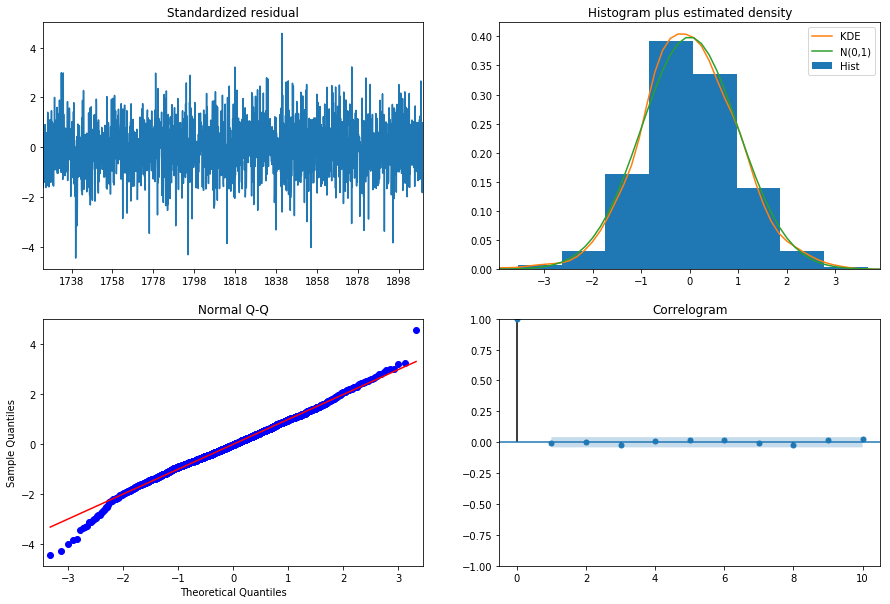

In [26]:
mod.plot_diagnostics(figsize=(15, 10))
plt.show()

<br /><br />
## 2.1.5. Build forecast for unused data (after 1910-01)

In [95]:
ts_tail=ts['1910-01':]

is_summer=np.zeros(len(ts_tail))
is_winter=np.zeros(len(ts_tail))

for i in range(len(ts_tail)):
    if '01' in ts_tail.index[i]:
        is_winter[i]=1
    
    if '07' in ts_tail.index[i]:
        is_summer[i]=1


myfit=sm.tsa.statespace.SARIMAX(ts_tail, exog=np.column_stack((is_summer, is_winter)), order=(1,0,2), seasonal_order=(2,1,1,12)).fit()

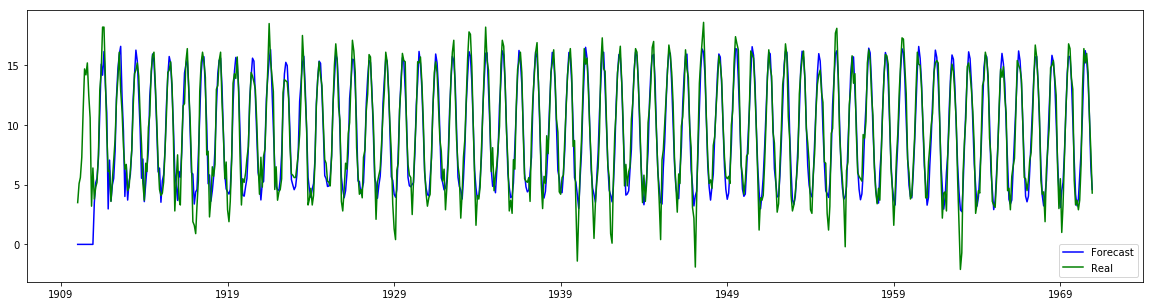

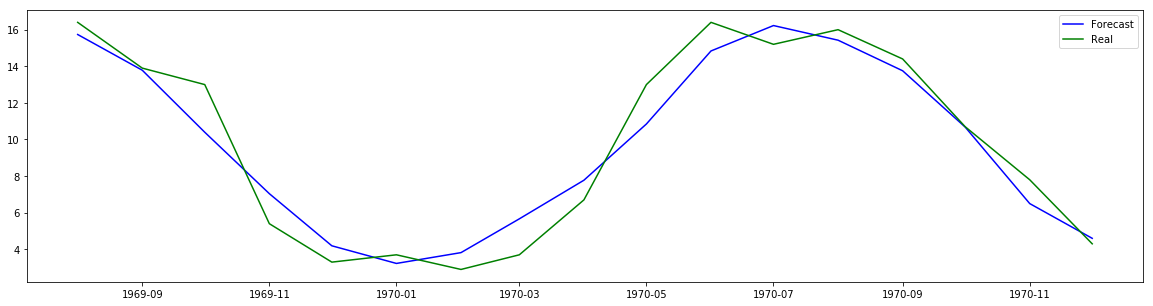

MACAPE Accuracy:
0.802490937826


In [101]:
plt.figure(figsize=(20,5))
plt.plot(myfit.predict().index,myfit.predict(), color='b', label='Forecast')
plt.plot(myfit.predict().index,np.array(ts_tail['Monthly temperature in England (F), 1723-1970']), color='g', label='Real')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(myfit.predict().index[715:],myfit.predict()[715:], color='b', label='Forecast')
plt.plot(myfit.predict().index[715:],np.array(ts_tail['Monthly temperature in England (F), 1723-1970'])[715:], color='g', label='Real')
plt.legend()
plt.show()

print("MACAPE Accuracy:")
print(1-qualityMACAPE(myfit.get_prediction().predicted_mean['1911-01':],ts_tail['Monthly temperature in England (F), 1723-1970']['1911-01':]))

<h3><span style="color:red">REPORT</span></h3>
1. The forecast looks appropriate
2. We have 2 reasons why using MACAPE is a bad idea
    1. MACAPE strongly depends on zero level, but we have Farenheite scale, where '0' value doesn't have physical meaning
    2. We have negative values, which strongly affect on MACAPE
3. Nevertheless we use MACAPE because it has understandable value. And despite 2 bad factors mentioned above, our MACAPE looks not so bad